In [19]:
import polars as pl
import numpy as np
import wave


def read_parquet(filename: str) -> pl.DataFrame:
    df1 = pl.read_parquet(f"data/{filename}")
    df1 = df1.with_row_count().with_columns(
        (pl.col("row_nr").cast(pl.Float32) / 20000.0 * 1000000000.0).cast(pl.Time).alias("time"))
    df1 = df1.with_columns(
        (pl.col("row_nr").cast(pl.Float32) / 20000.0).cast(pl.Float64).alias("seconds"))
    return df1


def convert_series_to_wav(series: pl.Series, path: str):
    diff = (series.max() - series.min()) / 2.0
    normalized_data = (series / diff * 20000).cast(pl.Int16)
    bytes = normalized_data.to_numpy().tobytes()
    with wave.open(path, 'w') as wav_file:
        wav_file.setnchannels(1)  # mono
        wav_file.setsampwidth(2)  # 2 bytes = 16 bit
        wav_file.setframerate(20000)  # common sample rate
        wav_file.setnframes(len(normalized_data))
        wav_file.writeframes(bytes)


files = [
    ("D4", "D0400001.parquet",),
    ("D6", "D0600001.parquet",),
    ("D8", "D0800001.parquet",),
    ("V2", "V2_00001.parquet",),
    ("V6", "V6_00001.parquet",),
    ("V10", "V10_0001.parquet"),
    ("V17", "V17_0001.parquet"),
    ("V20", "V20_0001.parquet"),
    ("V24", "V24_0001.parquet"),
    ("V25", "V25a_001.parquet"),
]


rename_d_columns = {
    "CH1_Moment": "moment",
    "CH2_Kraft": "force",
    "CH4_SyncSig": "sync signal",
    "CH5_a3_BOZA": "oil acceleration",
    "CH6_akustik": "acoustic",
    "CH3_Biegemo": "bending moment", # different
    'CH7_a4_Bohrst': "bohrst", # different
}

rename_v_columns = {
    "CH1_Moment": "moment",
    "CH2_Kraft": "force",
    "CH3_SyncSig": "sync signal",
    "CH7_a3_BOZA": "oil acceleration",
    "CH4_akustik": "acoustic",
    "CH5_a1_WSAS": "lateral acceleration", # different
    "CH6_a2_WSAF": "frontal acceleration", # different

}

dfs = {}

for (name, parquet_path) in files:
    df = read_parquet(parquet_path)
    if name[0] == "D":
        df = df.rename(rename_d_columns)
    else:
        df = df.rename(rename_v_columns)
    convert_series_to_wav(df["acoustic"], f"data/{name}.wav")
    lower_name = name.lower()
    dfs[lower_name] = df
    exec(f"{lower_name} = df")



# define the dataframes again because pylance too stupid to pick up the exec above
d4: pl.DataFrame = d4
d6: pl.DataFrame = d6
d8: pl.DataFrame = d8
v2: pl.DataFrame = v2
v6: pl.DataFrame = v6
v10: pl.DataFrame = v10
v17: pl.DataFrame = v17
v20: pl.DataFrame = v20
v24: pl.DataFrame = v24
v25: pl.DataFrame = v25

In [20]:
v17

row_nr,moment,force,sync signal,acoustic,lateral acceleration,frontal acceleration,oil acceleration,time,seconds
u32,f32,f32,f32,f32,f32,f32,f32,time,f64
0,12.584,-92.987999,11.5464,0.223717,-3.1496,-1.9056,0.38,00:00:00,0.0
1,-1.3068,-39.032001,11.5456,0.295259,-4.78,-2.5024,1.75,00:00:00.000050,0.00005
2,-6.1468,45.919998,11.5464,0.35692,-3.4696,-1.9144,0.25,00:00:00.000100,0.0001
3,2.42,-6.888,11.547999,0.401979,-2.8912,1.3664,2.5,00:00:00.000150,0.00015
4,0.484,-91.839996,11.547199,0.389726,-4.1064,0.0584,1.19,00:00:00.000200,0.0002
5,3.2428,94.136002,11.5456,0.374706,-0.2224,-3.2656,-0.37,00:00:00.000250,0.00025
6,4.356,84.952003,11.547199,0.421742,2.2312,-6.6608,4.64,00:00:00.000300,0.0003
7,1.7424,8.036,11.5504,0.352967,2.0496,-8.7992,5.73,00:00:00.000350,0.00035
8,-1.3068,-177.940002,11.5512,0.171543,5.08,-11.1384,0.48,00:00:00.000400,0.0004


look at all the header files:

```
| df  | filename           | comments                                                                   | columns                                                                                  |
| --- | ------------------ | -------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| d4  | "D0400001.parquet" | vc=111m/min, f=0.231mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| d6  | "D0600001.parquet" | vc=120m/min, f=0.185mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| d8  | "D0800001.parquet" | vc=90m/min, f=0.250mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar  | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| v2  | "V2_00001.parquet" | vc=120 mm/min, f=0.185                                                     | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v6  | "V6_00001.parquet" | Schneiden 2, v_c=111 m/min, f=0.231 mm, V_oel=371 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v10 | "V10_0001.parquet" | Schneiden 4, v_c=111 m/min, f=0.231 mm, V_oel=229 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v17 | "V17_0001.parquet" | Schneiden 6, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v20 | "V20_0001.parquet" | Schneiden 8, v_c=90 m/min, f=0.250 mm, V_oel=300 l/min                     | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v24 | "V24_0001.parquet" | Schneiden 12, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                   | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v25 | "V25a_001.parquet" | Schneiden 13, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                   | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
```


now listen to audio manually to see if we can hear the chatter coming at some point. Then note these values down:

```
d4, d6, d8 had no chatter.

v2:  0:10 normal   3:20.25  chatter                                                     4:24 end
v6                 0:47.40  first chatter                         2:16 second chatter   4:13 end
v10                0:47.35  first chatter                         1:31 second chatter   4:12 end
v17                0:34.50  first chatter                         0:45 second cahtter   4:30 end
v20                0:52.50  first chatter   1:36 almost normal    1:47 second chatter   4:47 end
v24                0:21.60  first chatter                         1:04 second chatter   4:18 end
v25                1:58.50  chatter                                                     4:20 end
```


d4: 03:54
d6: 04:28
d8: 04:27
v2: 04:51
v6: 04:25
v10: 04:25
v17: 04:44
v20: 04:58
v24: 04:29
v25: 04:33


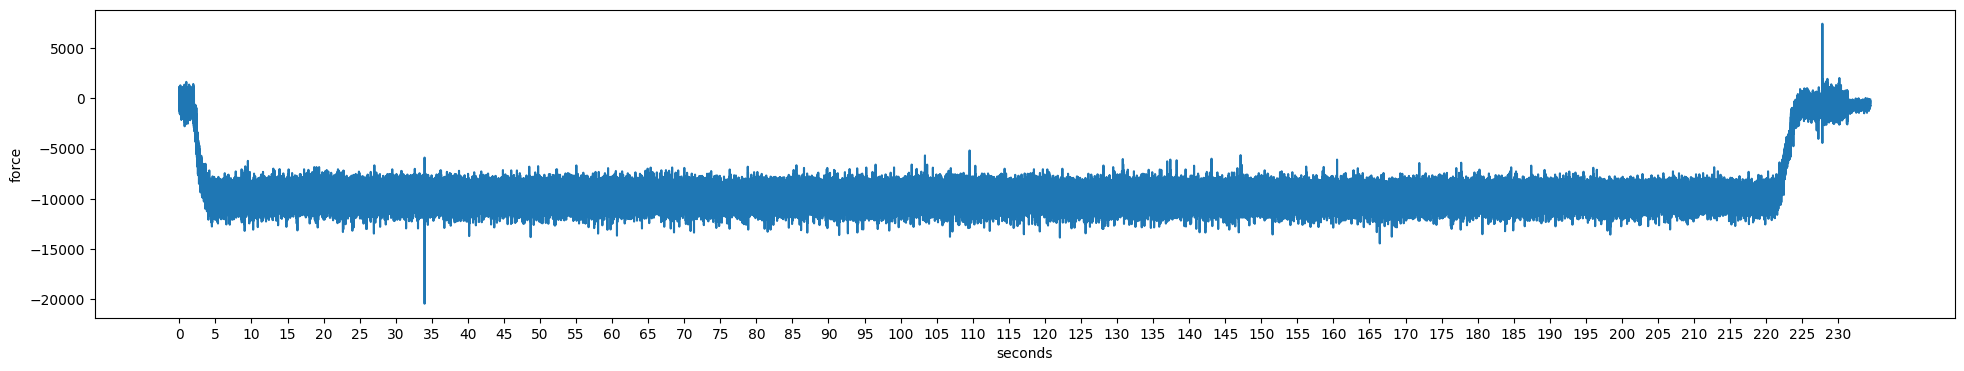

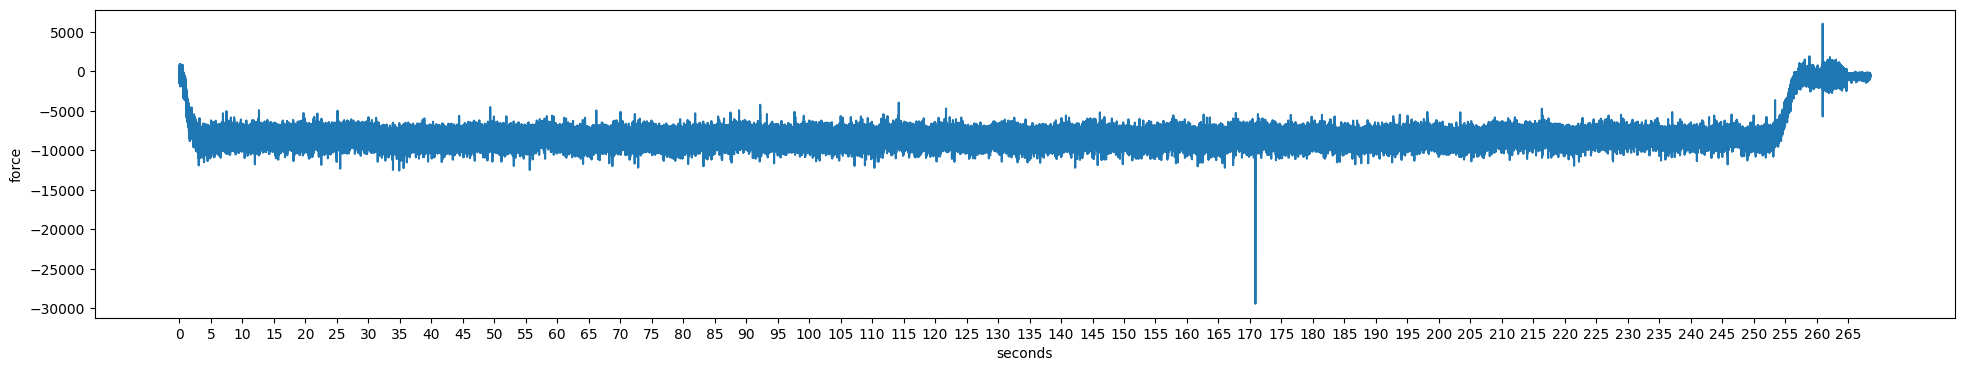

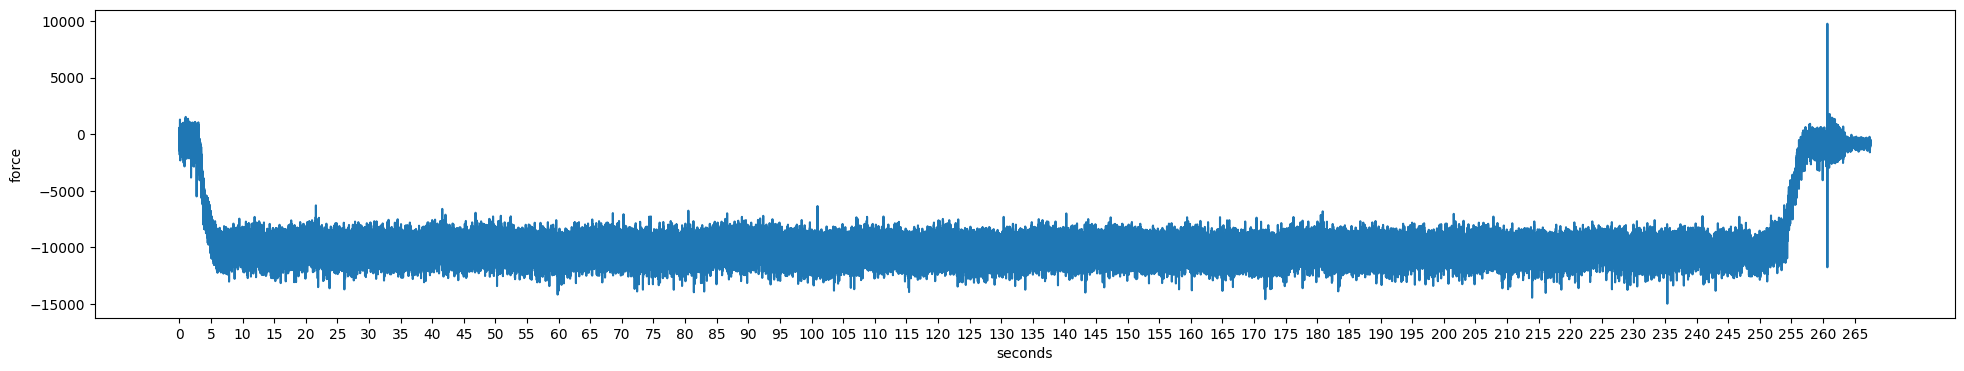

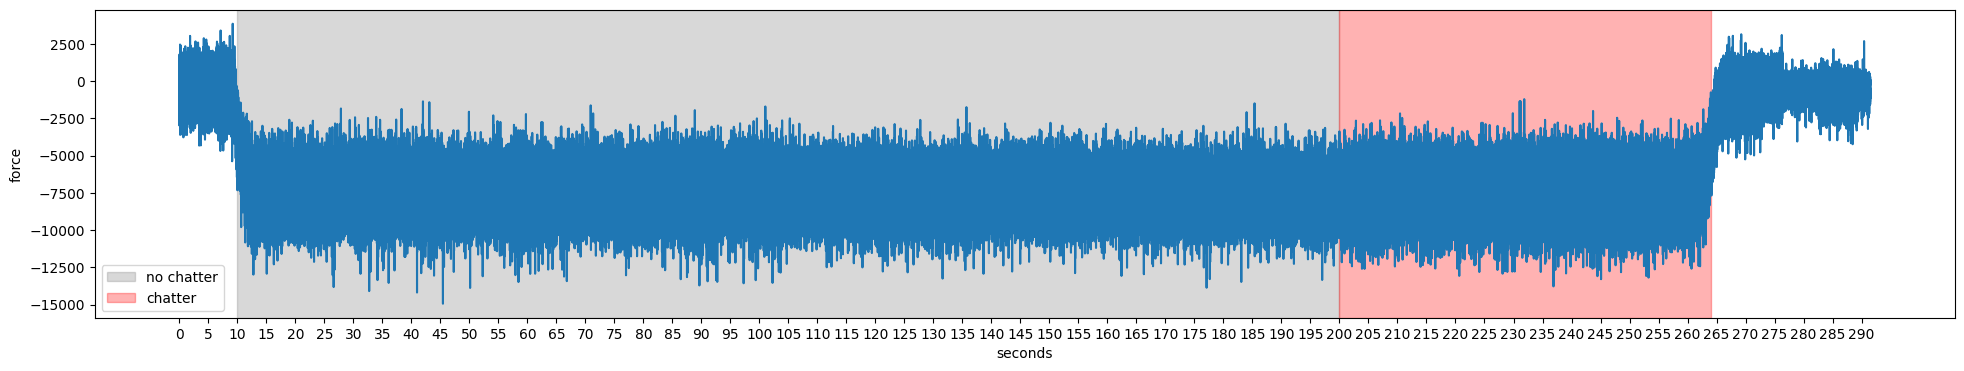

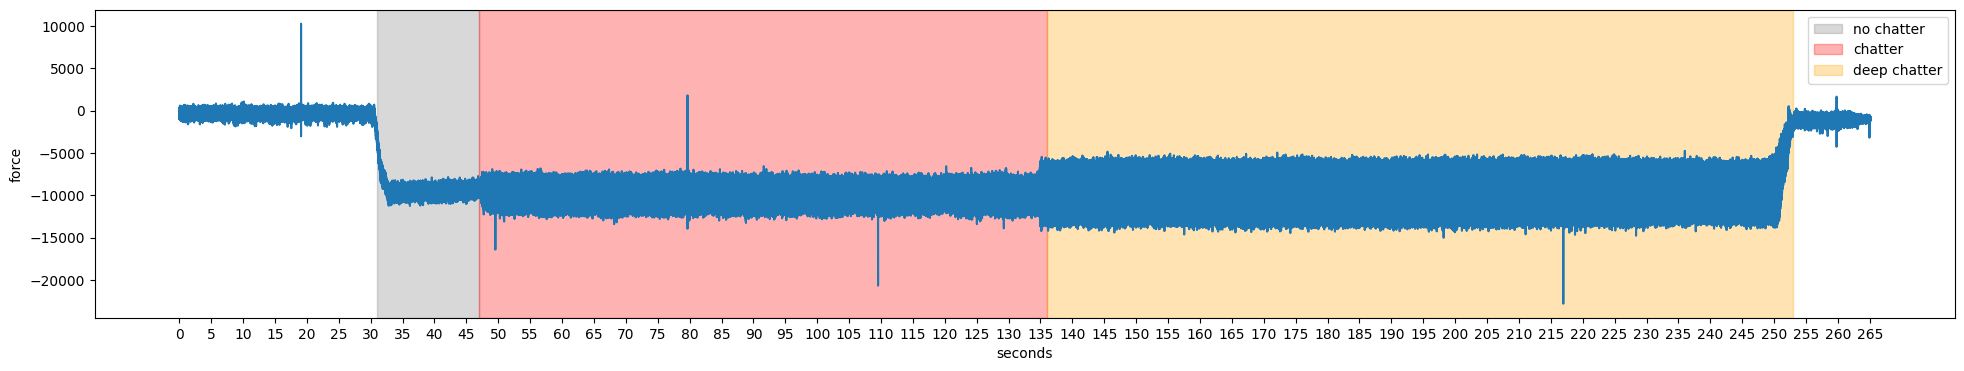

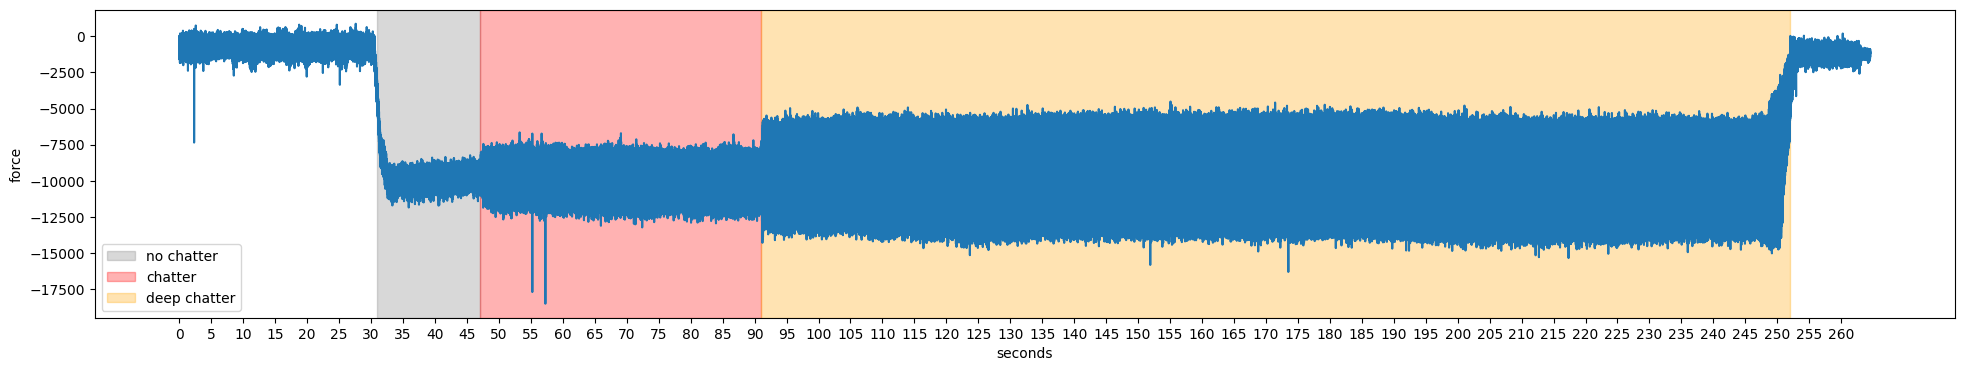

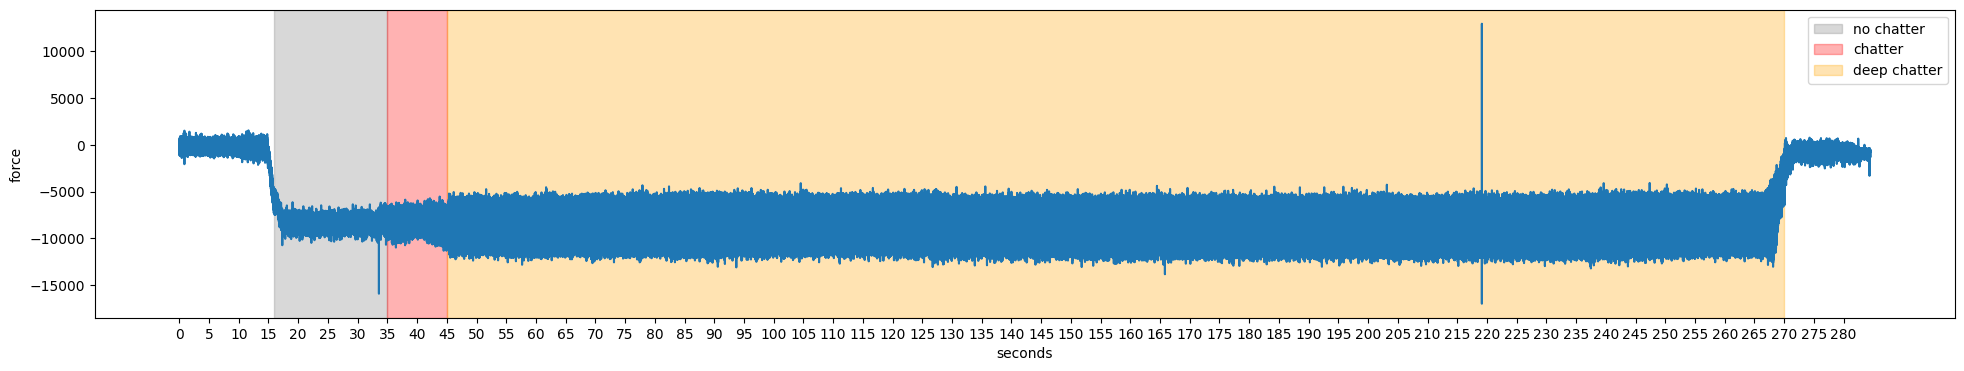

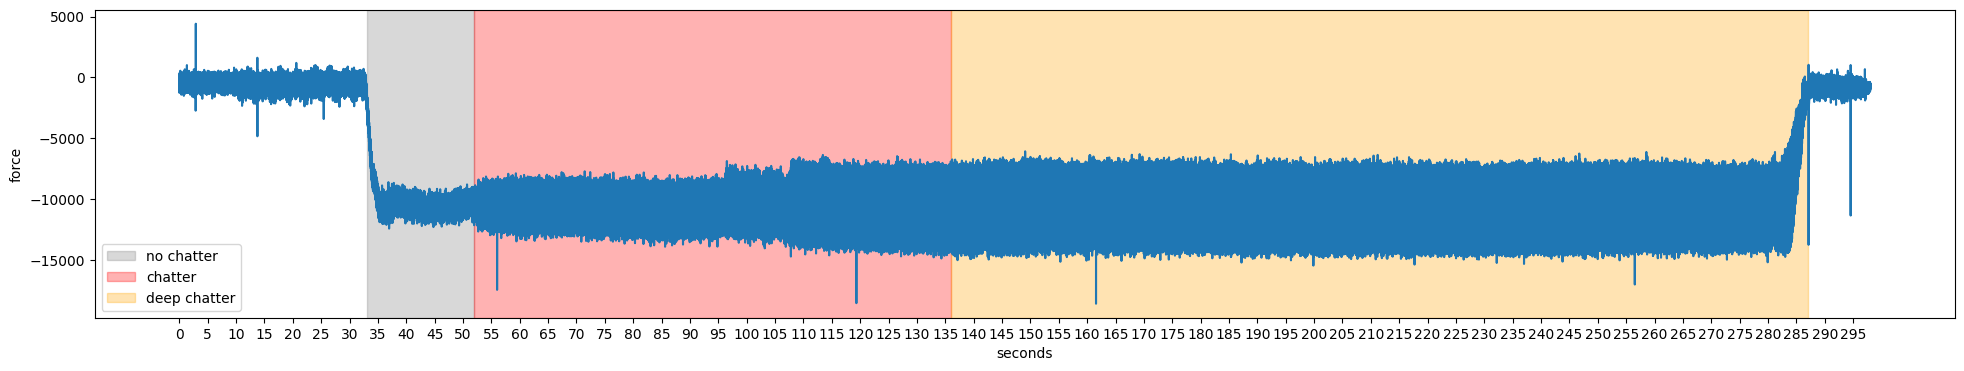

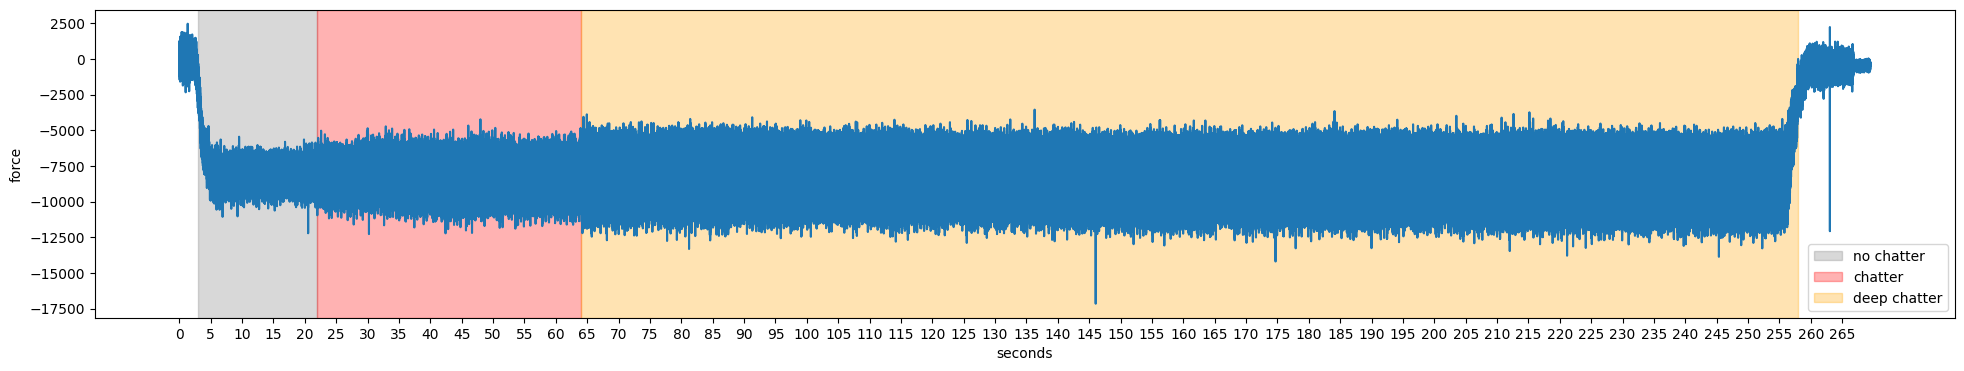

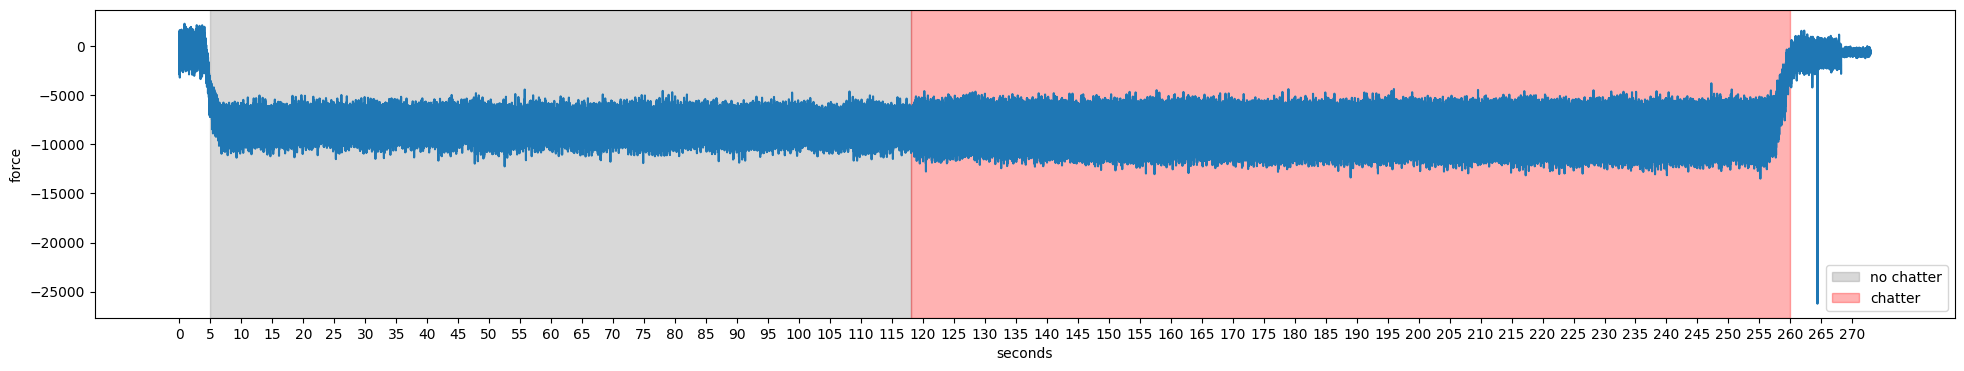

In [47]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt

regions = {
    "v2": [("no chatter", 10, 200), ("chatter", 200, 264)],
    "v6": [("no chatter", 31, 47), ("chatter", 47, 136), ("deep chatter", 136, 253)],
    "v10": [("no chatter", 31, 47), ("chatter", 47, 91), ("deep chatter", 91, 252)],
    "v17": [("no chatter", 16, 35), ("chatter", 35, 45), ("deep chatter", 45, 270)],
    "v20": [("no chatter", 33, 52), ("chatter", 52, 136), ("deep chatter", 136, 287)],
    "v24": [("no chatter", 3, 22), ("chatter", 22, 64), ("deep chatter", 64, 258)],
    "v25": [("no chatter", 5, 118), ("chatter", 118, 260)],
}


def add_regions(df_name, fig: Figure, ax: Axes):
    reg: list[(str, int, int)] = regions[df_name]
    for (name, start, end) in reg:
        color =  {"chatter": "red", "deep chatter": "orange", "no chatter": "grey"}[name]
        ax.axvspan(start, end, color=color, alpha=0.3, label=name)

for name in dfs:
    seconds = dfs[name].__len__()/20000
    # print the seconds as a formatted duration
    print(f"{name}: {seconds//60:02.0f}:{seconds%60:02.0f}")

for name in dfs:
    # plot the force:
    df = dfs[name]
    fig, ax = plt.subplots(figsize=(24, 4))
    # plot the seconds on the x axis of ax
    ax.plot(df["seconds"], df["force"])
    ax.set_xlabel("seconds")
    ax.set_ylabel("force")
    
# put ticks for every second
    ax.set_xticks(np.arange(0, df["seconds"].max(), 5))

    if regions.get(name) is not None:
        add_regions(name, fig, ax)
        ax.legend()    
    plt.show()


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_acf_for_region(df: pl.DataFrame, column: str, start_sec: float, end_sec: float, nlags: int = 30, save_path: str = None, title: str = None):
    acf = sm.tsa.stattools.acf(
        df[column][int(20000*start_sec):int(20000*end_sec)], nlags=nlags)
    plt.stem(acf)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    if title is not None:
        plt.title(title)
    plt.show()
    if save_path is not None:
        plt.savefig(save_path)


v_columns = ["CH1_Moment", "CH2_Kraft", "CH3_SyncSig",
             "CH4_akustik", "CH5_a1_WSAS", "CH6_a2_WSAF", "CH7_a3_BOZA"]
# for each of the relevant columns plot the acf druing chattering and non-chattering
df_and_regions = [(v2, "v2", (10, 200), (200, 264), None),
                  (v6, "v6", (10, 47), (47, 136), (91, 253)),
                  (v10, "v10", (10, 47), (47, 91), (91, 252)),
                  (v17, "v17", (10, 34), (34, 45), (45, 270)),
                  (v20, "v20", (10, 52), (52, 136), (147, 287)),
                  (v24, "v24", (10, 21.6), (21.6, 64), (64, 258)),
                  (v25, "v25", (10, 118), (118, 260), None),]

for (df, name, non_chattering_region, chattering_region, chattering_region2) in df_and_regions:
    (non_start, non_end) = non_chattering_region
    (chattering_start, chattering_end) = chattering_region
    for column in v_columns:
        plot_acf_for_region(df, column, non_start, non_end,
                            title=f"{name}_{column}_non_chattering")  # todo: savepath
        plot_acf_for_region(df, column, chattering_start, chattering_end,
                            title=f"{name}_{column}_chattering")  # todo: savepath
        if chattering_region2 is not None:
            (chattering_start2, chattering_end2) = chattering_region2
            plot_acf_for_region(df, column, chattering_start2, chattering_end2,
                                title=f"{name}_{column}_chattering_region_2")  # todo: savepath

    #
    # if chattering_region2 is not None:
    #     (chattering_start2, chattering_end2) = chattering_region2

# plot_acf_for_region(v6, "CH4_akustik", 20, 30)
# plot_acf_for_region(v6, "CH4_akustik", 50, 100)

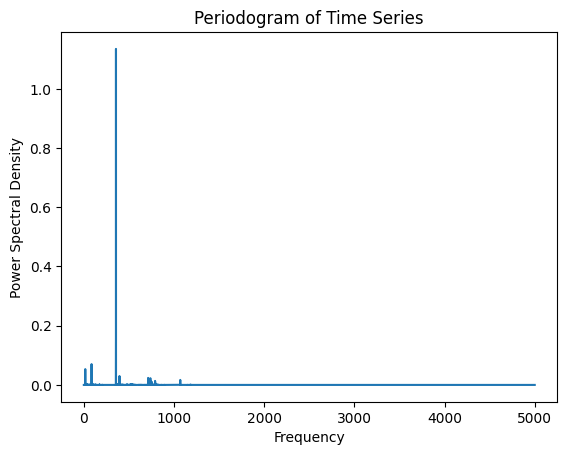

In [36]:
from scipy import signal

frequencies, spectrum = signal.periodogram(
    v2["CH4_akustik"][20000*200: 20000*260], 10000)

# Plot the periodogram
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram of Time Series')
plt.show()